## Cell image classifier using opencv 

The key observation is that at the center of the class B and C cells is a duplication of the nuclei. This can be discriminated using EM segmentation of the 2-D 16bit image plane using 7 clusters; however, you must include locality, you need to be able to feed super-pixels into the EM algorithm. With that setting, there's a distinction that can be made between Class B and C, and then, size of the two smallest EM clusters can be used to differentiates Class A from B.

Process: 

1. EM segementation into 7 components 
2. Ordering Segments by intensity.
3. Shape Intersetcions between the smallest two segementations (with highest intensities).
4. Simple Classifier.


In [1]:
import sys, os, glob
import cv2
import sklearn, math
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import tifffile as tiff
from scipy.misc import bytescale
import PIL
import pandas as pd

home_dir = os.path.abspath('./');print(home_dir)
ud = '/tdata1/luminex_challenge/'


/home/ubuntu/git/luminex_dsuciu


## 0. Helper Functions

In [5]:
def import_bytescale(img_p):
    img16 = np.int16(cv2.imread(img_p, -1))
    img8 = bytescale(img16)
    return img8

def importImage16b(img_p):
    img = cv2.imread(img_p, -1)
    return img

def import_images(plst, import_funct=import_bytescale):
    oLst = []
    for imgp in plst:
        oLst.append(import_funct(imgp))
        image_stats(oLst[-1], end='\r')
    return oLst


def image_stats(img, end='\n'):
    x = img.flatten()
    px = 0
    if len(img.shape)==3:
        h,w,px = img.shape
    else:
        h,w = img.shape
    print ("type: %s dtype: %s sz: %s, max_val: %i pixels>0: %i of %i"%(str(type(img)), img.dtype, str(img.shape), x.max(), len(x[x>0]), h*w), end=end)

def image_histo(img):
    if len(img.shape)==2:
        image_stats(img)
        x = img.flatten()
        c,vv,pp = plt.hist(x[x>0], 50, density=False, facecolor='g', alpha=0.75)
    else:
        color = ('b','g','r')
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
            plt.ylabel('log pixel color counts')
            plt.yscale('log')
            
def colorize(img_gray, colormap=cv2.COLORMAP_JET):
    #https://www.learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
    """0	COLORMAP_AUTUMN	colorscale_autumn
        1	COLORMAP_BONE	colorscale_bone
        2	COLORMAP_JET	colorscale_jet
        3	COLORMAP_WINTER	colorscale_winter
        4	COLORMAP_RAINBOW	colorscale_rainbow
        5	COLORMAP_OCEAN	colorscale_ocean
        6	COLORMAP_SUMMER	colorscale_summer
        7	COLORMAP_SPRING	colorscale_spring
        8	COLORMAP_COOL	colorscale_cool
        9	COLORMAP_HSV	colorscale_hsv
        10	COLORMAP_PINK	colorscale_pink
        11	COLORMAP_HOT	colorscale_hot"""
    return cv2.applyColorMap(img_gray, colormap)

def image_show_histo(img, figsize=(10,5)):
    image_stats(img)
    x = img.flatten()
    plt.figure(figsize=figsize)
    columns=2
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(colorize(img))
    plt.subplot(1, 3, 3)
    image_histo(img)#plt.hist(x[x>0], 25, density=False, cumulative=False, facecolor='g', alpha=0.75)
        

def plotImages(lst, columns=10, figsize=(20,10), PlotHisto=False):
    plt.figure(figsize=figsize)
    n = len(lst)
    for i, image in enumerate(lst):
        plt.subplot(n / columns + 1, columns, i + 1)
        if PlotHisto:
            x = image.flatten()
            c,vv,pp = plt.hist(x[x>0], PlotHisto, density=False, facecolor='g', alpha=0.75)
        else: plt.imshow(image)
        
def multiplot(lst, columns=10, figsize=(20,10)):
    plt.figure(figsize=figsize)
    n = len(lst)
    for i, plot in enumerate(lst):
        plt.subplot(n / columns + 1, columns, i + 1)
        plt.show(plot)

#### Because the images are 16bit, importing them using CV_8UC1 actually loses data since it overflows the uint8 leading to undefined behavior. bytescale is nice, but it also looses data. Both successful segmentation approaches used the full 16bit data channel.

In [6]:
#glob Filenames:
fileLst = glob.glob(ud + "class*/*tif")
fileLst.sort()
imgLst_u8 = import_images(fileLst, import_funct=import_bytescale)
imgLst_u16 = import_images(fileLst, import_funct=importImage16b)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  This is separate from the ipykernel package so we can avoid doing imports until


#### The three rows below are class A, B and C, respectively.

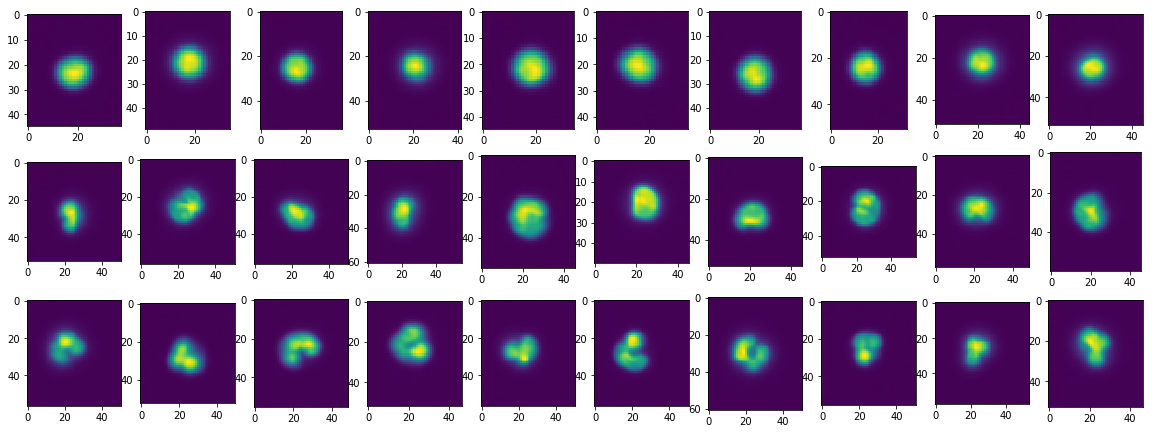

In [182]:
#Load ImageLst:
plotImages(imgLst_u8)

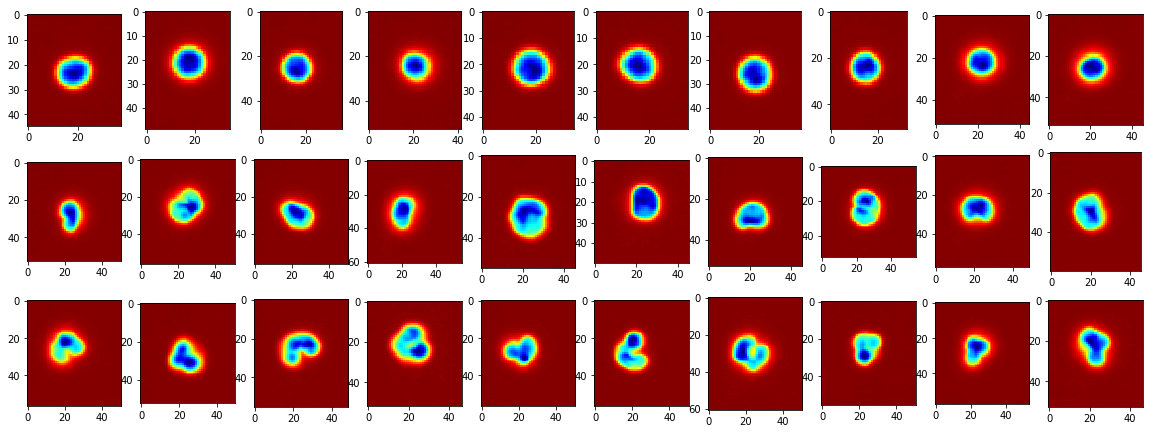

In [479]:
plotImages([colorize(img_gray) for img_gray in imgLst_u8])

## 1. 2-D Clustering Methods:

EM clustering allows us to separate the nuclei into distinct segments. 

In [35]:
def getsamples_img(img, data_weight=1.0):
    """This part is critical:
    Generating the pixel points (x,y,val), introduces locality into the 
    segmentation calculation normalizing all the columns and then 
    playing with the data_weight we give to the data over the x,y points 
    affects our ability to generate decent segmentation for the nuclei.
    It also makes this process very 'heuristicky' """
    r, c = img.shape
    out_arr = np.zeros((r*c,3), dtype=np.float)
    idx = 0
    for i in range(r):
        for j in range(c):
            v = img[i][j]
            out_arr[idx] = np.array([float(i),float(j),v])
            idx+=1
    out_arr = out_arr / out_arr.sum(axis=0)*np.array([1.0,1.0,data_weight])
    return out_arr

def getsamples_img1D(img):
    #Does not work!!!
    r, c = img.shape
    out_arr = np.zeros((r*c,3), dtype=np.float)
    idx = 0
    for i in range(r):
        for j in range(c):
            v = img[i][j]
            out_arr[idx] = np.array([v])
            idx+=1
    out_arr = out_arr / out_arr.sum(axis=0)
    return out_arr

def RunEMSegmentation(img, init_clusters=4, data_weight=1.0):
    X_train = getsamples_img(img, data_weight=data_weight)#getsamples_img1D(img)#  
    em = cv2.ml.EM_create()
    em.setClustersNumber(init_clusters)
    _, v, classLst, probs = em.trainEM(X_train)
    classLst = classLst.flatten()
    means = em.getMeans()
    num_clusters = len(means)
    #print(num_clusters, means)
    x, y = img.shape
    output_img = np.zeros((x,y), dtype=np.uint8)
    idx=0
    for i in range(x):
        for j in range(y):
            output_img[i,j] = classLst[idx]
            idx+=1
    unique, counts = np.unique(classLst, return_counts=True)
    #print ("EM: ", unique, counts)
    num_classes = len(np.unique(num_clusters))
    cm = []
    for c in range(num_clusters):
        class_idxLst = np.argwhere(classLst==c).flatten()
        cm.append(np.mean(probs[class_idxLst], axis=0))
    cm = np.array(cm)
    return ReorderClassesByIntensity(output_img, img.flatten())

def ReorderClassesByIntensity(img, orig_img):
    h,w=img.shape
    x=img.flatten()
    num_clusters=len(np.unique(x))
    cluster_szLst = []
    for c in range(num_clusters):
        cluster_szLst.append([c, np.mean(orig_img[np.argwhere(x==c)])])
    out_img = np.zeros(h*w, dtype=np.uint8)
    cluster_szLst.sort(key=lambda x:x[1])
    for c in range(num_clusters):
        orig_c = cluster_szLst[c][0]
        out_img[np.argwhere(x==orig_c)] =c
    return out_img.reshape(img.shape)

def floodFillShape(mask):
    x,y = mask.shape
    mask1 = np.zeros([x+2,y+2], np.uint8)
    cv2.floodFill(mask.copy(),mask1,(0,0),True)
    mask_inv=cv2.bitwise_not(mask1)
    return mask_inv[:-2,:-2]-254

def AndOrShape(m1, m2, Verbose=False):
    ff = floodFillShape(m1).astype(np.bool)
    a = ff&m2
    o = ff|m2
    ret = [imidx, m1.sum(), m2.sum(), a.sum(), o.sum(), a.sum()/o.sum()]
    if Verbose:
        print(ret)
        plotImages([m1, m2, ff, a, o])
    return ret

### Run One EM across three classes: 
This allowed me to find the right cluster size and conditions to distinguish the size of classA cells and the classC appearance of the splitting of nuclei.  
What made it work was the following: 
1. thresholding to get rid of non-cell areas.
2. choosing the right number of clusters. 
3. balancing between the xy points and the weight of the actual data in the EM data generation. 


type: <class 'numpy.ndarray'> dtype: uint8 sz: (49, 35), max_val: 7 pixels>0: 378 of 1715
type: <class 'numpy.ndarray'> dtype: uint8 sz: (49, 35), max_val: 7 pixels>0: 378 of 1715
type: <class 'numpy.ndarray'> dtype: uint8 sz: (57, 51), max_val: 7 pixels>0: 518 of 2907
type: <class 'numpy.ndarray'> dtype: uint8 sz: (57, 51), max_val: 7 pixels>0: 518 of 2907
type: <class 'numpy.ndarray'> dtype: uint8 sz: (53, 50), max_val: 7 pixels>0: 420 of 2650
type: <class 'numpy.ndarray'> dtype: uint8 sz: (53, 50), max_val: 7 pixels>0: 420 of 2650


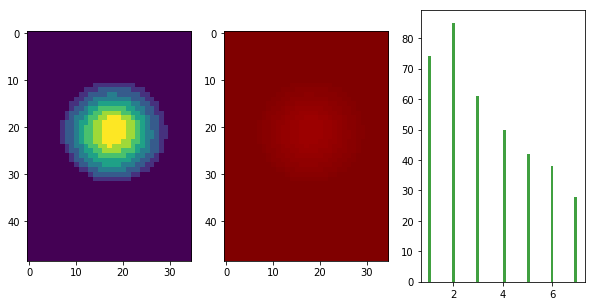

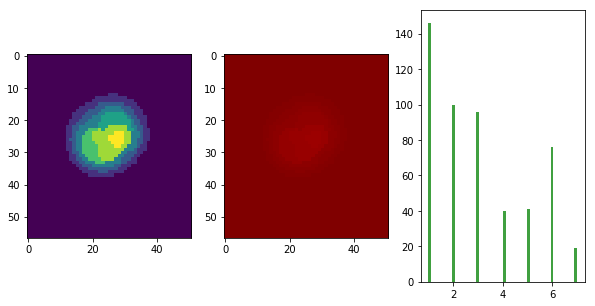

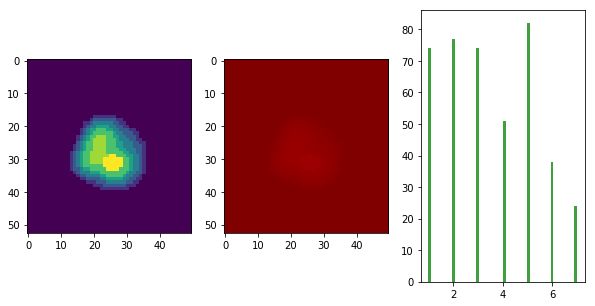

In [36]:
cl=8;w=5
idx = 1
tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
ret1,thrtif_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
oimg = RunEMSegmentation(thrtif_img, init_clusters=cl, data_weight=w)
x = oimg.flatten()
#print ("\n\nx[x>0]", x[x>0])
image_show_histo(oimg, figsize=(10,5))

idx = 11
tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
ret1,thrtif_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
oimg2 = RunEMSegmentation(thrtif_img, init_clusters=cl, data_weight=w)
x = oimg2.flatten()
image_show_histo(oimg2, figsize=(10,5))

idx = 21
tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
ret1,thrtif_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
oimg3 = RunEMSegmentation(thrtif_img, init_clusters=cl, data_weight=w)
x = oimg3.flatten()
image_show_histo(oimg3, figsize=(10,5))

### EM for all 30 images:  
Ordering the colors by intensity, and choosing a cluster_size of 7 gets more revealing segmentation of the nuclei.

In [37]:
num_clusters=7
em_imgLst = []
for idx in range(30):
    tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
    ret1,thresh_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
    oimg = RunEMSegmentation(thresh_img, init_clusters=num_clusters, data_weight=5.0)
    em_imgLst.append(oimg)

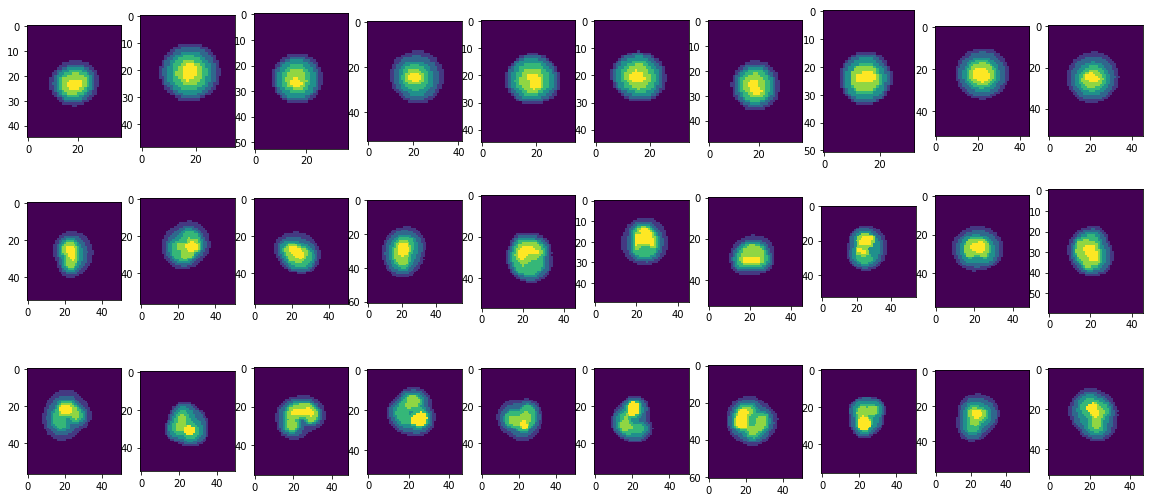

In [38]:
plotImages(em_imgLst, figsize=(20,12))

### The key is to order the segmentations by intensity, and then to look at size and shape intersections of the smallest (and most intense) segements. These are presumably the (stained?) nuclei. 

The function AndOrShape looks for blobs that are within or adjacent to each other. Adjacency implies duplication and separation, and thus classC. The other two classes can be distinguished based on their size. 

In [39]:
em_contourLst = []
mLst = [];cntLst=[];andor=[]
for imidx in range(30):
    print(imidx, end='\r')
    img = em_imgLst[imidx]
    img_shape = img.shape
    x = img.flatten()
    img_sz = np.prod(img_shape)
    num_clusters = len(np.unique(x))
    for c in range(5,7,1):
        mask_img = np.zeros(img_sz, dtype=np.uint8)
        mask_img[np.argwhere(x==c)]=1
        mask_img = mask_img.reshape(img_shape)
        mLst.append(mask_img)
    m1 = mLst[-2]
    m2 = mLst[-1]
    andor.append(AndOrShape(m1, m2, Verbose=False))

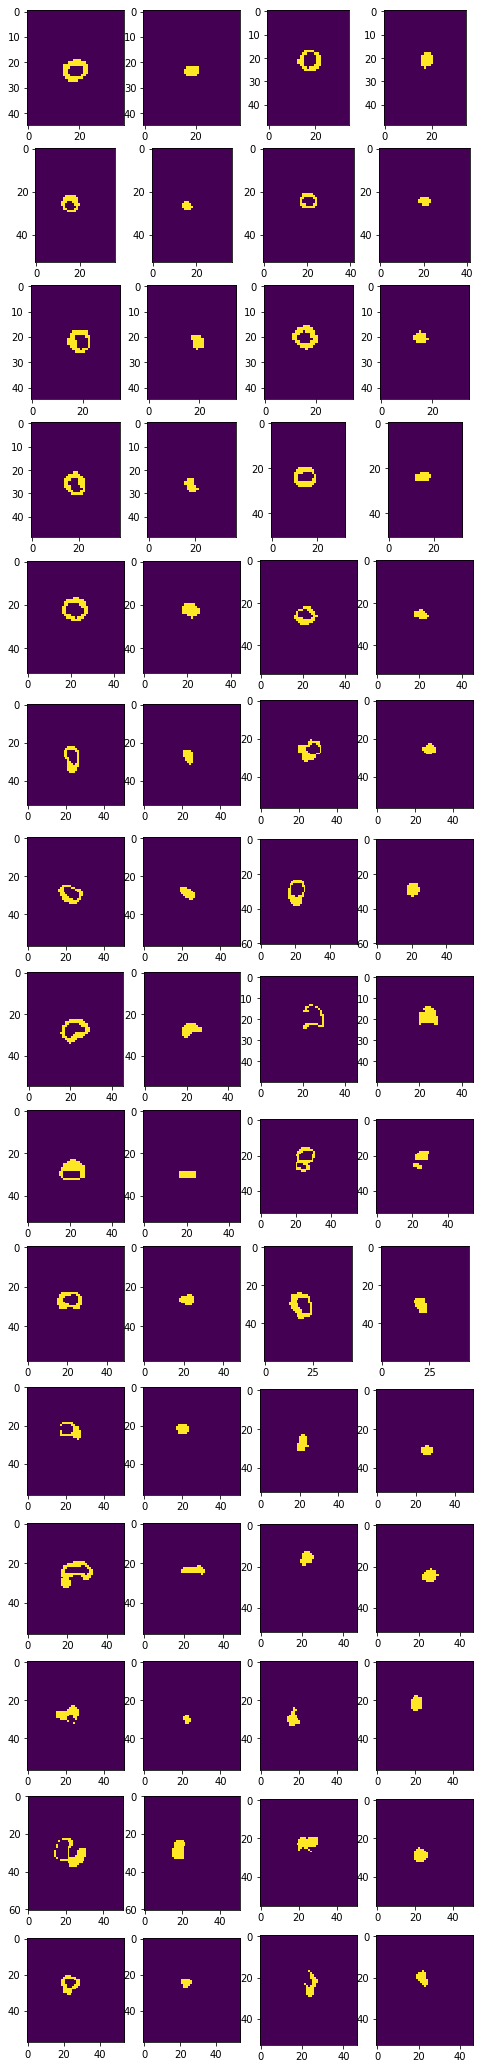

In [40]:
plotImages(mLst, columns = 4,figsize=(8,40))

In [41]:

for i in range(len(andor)):
    r = andor[i]
    if r[5]<0.105:
        clss = 'C'
    elif r[1] <55:
        clss = 'A'
    else:
        clss = 'B'
    andor[i].append(clss)
    
df = pd.DataFrame(andor, columns=['idx', 'segment_6_count', 'segment_7_count', 'and', 'or', 'and/or', 'class'])
df

,idx,segment_6_count,segment_7_count,and,or,and/or,class
0,0,49,21,21,70,0.300000,A
1,1,42,28,28,70,0.400000,A
2,2,40,14,14,54,0.259259,A
3,3,30,19,19,49,0.387755,A
4,4,44,22,22,66,0.333333,A
5,5,48,20,20,68,0.294118,A
6,6,47,23,23,70,0.328571,A
7,7,53,24,24,77,0.311688,A
8,8,60,42,42,102,0.411765,B
9,9,46,24,22,72,0.305556,A


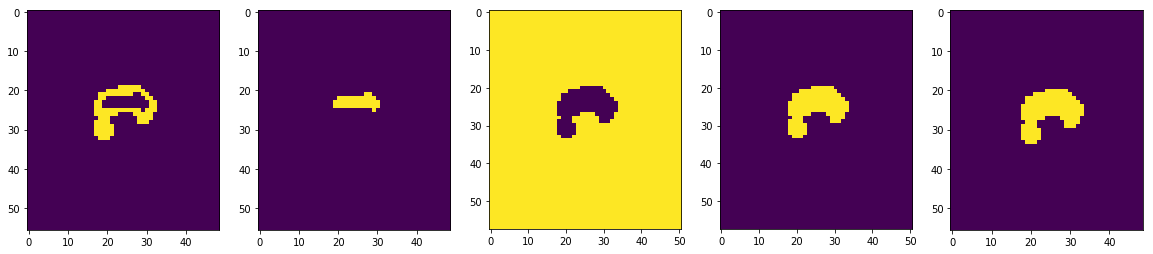

In [46]:
m1 = mLst[44]
m2 = mLst[45]

#floodfill

x,y = m1.shape
mask1 = np.zeros([x+2,y+2], np.uint8)
cv2.floodFill(m1.copy(),mask1,(0,0),True)
mask_inv=cv2.bitwise_not(mask1)
ff= mask_inv[:-2,:-2]-254

plotImages([m1, m2, mask1, mask_inv, ff], columns = 5)